In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_path = "E://Blockhouse/merged_data.csv"
data = pd.read_csv(file_path)
data.head()

,ts_event,bid_fill,ask_fill,Signed Volume,price,best_bid,best_ask,mid_price
0,2024-10-22 08:00:00,801.0,1999.0,-1198.0,236.14,235.83,236.14,235.985
1,2024-10-22 08:00:01,201.0,202.0,-1.0,236.13,235.83,236.13,235.980
2,2024-10-22 08:00:02,1600.0,1400.0,200.0,235.83,235.83,236.11,235.970
3,2024-10-22 08:00:03,534.0,400.0,134.0,236.10,235.96,236.10,236.030
4,2024-10-22 08:00:04,400.0,502.0,-102.0,236.11,235.96,236.11,236.035


Task1: Construct and code the linear OW model and nonlinear AFS model, and visualize the distri-
bution of price impact based on the given data.

In [3]:
def linear_ow_model(volume, lambda_linear=0.01):
    """
    Linear OW Model: Price impact is proportional to the traded volume.
    price_impact = lambda_linear * volume
    """
    return lambda_linear * volume


def nonlinear_afs_model(volume, lambda_nonlinear=0.005, exponent=0.5):
    """
    Nonlinear AFS Model: Price impact follows a power law of the traded volume.
    price_impact = lambda_nonlinear * sign(volume) * |volume|^exponent
    """
    return lambda_nonlinear * np.sign(volume) * np.abs(volume) ** exponent

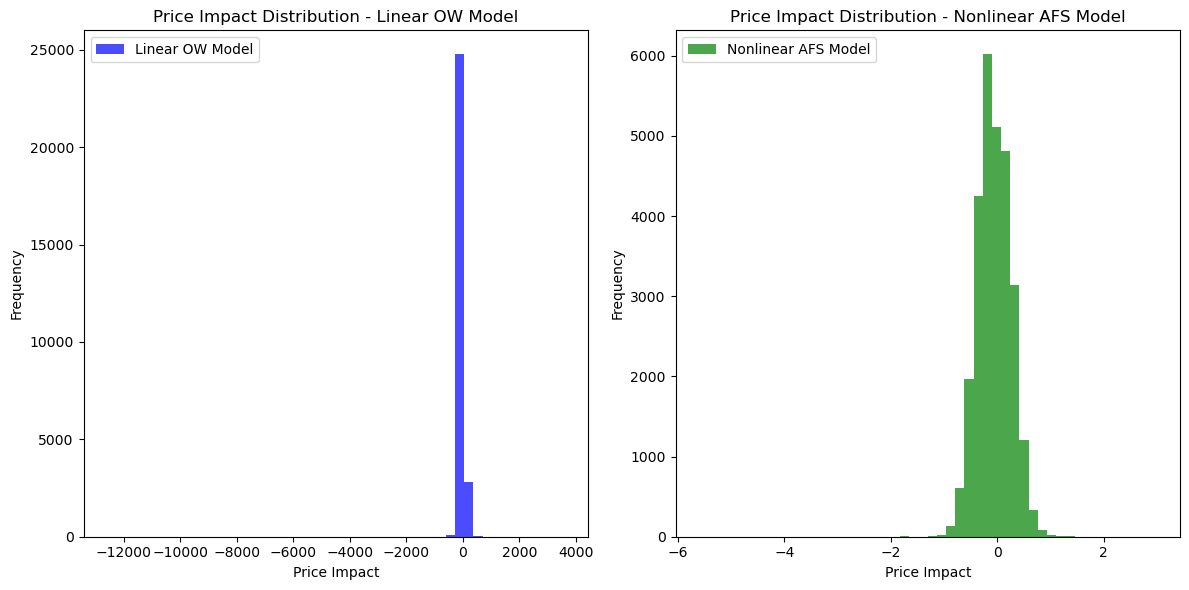

In [4]:
# Compute price impact using both models
data['price_impact_linear'] = linear_ow_model(data['Signed Volume'])
data['price_impact_nonlinear'] = nonlinear_afs_model(data['Signed Volume'])

# Plotting the distributions of price impact
plt.figure(figsize=(12, 6))

# Linear OW model
plt.subplot(1, 2, 1)
plt.hist(data['price_impact_linear'], bins=50, color='blue', alpha=0.7, label='Linear OW Model')
plt.title('Price Impact Distribution - Linear OW Model')
plt.xlabel('Price Impact')
plt.ylabel('Frequency')
plt.legend()

# Nonlinear AFS model
plt.subplot(1, 2, 2)
plt.hist(data['price_impact_nonlinear'], bins=50, color='green', alpha=0.7, label='Nonlinear AFS Model')
plt.title('Price Impact Distribution - Nonlinear AFS Model')
plt.xlabel('Price Impact')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

Task2: Implement and code the optimal strategy with Linear Impact and visualize the Sharpe Ratio
plots in Section 6.2.

Objective:

Implement the optimal linear trading strategy considering price impact.

Visualize the Sharpe Ratio across different parameters: price impact level (λ) and decay rate (β).

In [5]:
# Define parameters for the simulation
alpha = 0.01  # Predictive signal strength
beta_values = np.linspace(4, 7, 50)  # Range of beta values for decay rate
lambda_values = np.linspace(0.01, 0.03, 50)  # Range of lambda values for price impact
gamma = 0.1  # Risk aversion

In [7]:
def compute_coefficients(alpha, beta, gamma, sigma=0.02):
    """
    Compute coefficients Cf and CJ for the linear strategy based on given parameters.
    """
    cf = (alpha * (1 + beta)) / (gamma * sigma**2 * (np.sqrt(1 + (2 * beta) / (gamma * sigma**2))))
    cj = np.sqrt(1 + (2 * beta) / (gamma * sigma**2)) - 1
    return cf, cj

def sharpe_ratio(cf, cj, beta, lambda_):
    """
    Compute the Sharpe Ratio given coefficients and parameters.
    """
    numerator = cf * alpha - cj * beta * lambda_
    denominator = np.sqrt(cj * gamma)
    return numerator / denominator

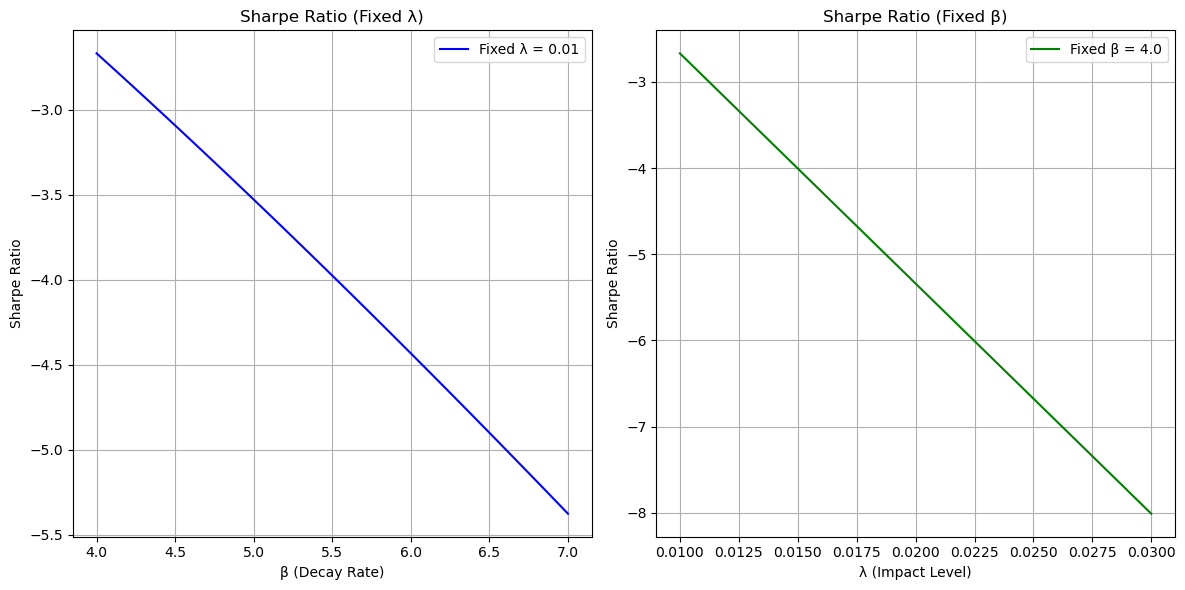

In [8]:
# Simulate Sharpe Ratios for fixed lambda and fixed beta cases
sharpe_ratios_fixed_lambda = []
sharpe_ratios_fixed_beta = []

# Fixed lambda case
for beta in beta_values:
    cf, cj = compute_coefficients(alpha, beta, gamma)
    sharpe_ratios_fixed_lambda.append(sharpe_ratio(cf, cj, beta, lambda_values[0]))

# Fixed beta case
for lambda_ in lambda_values:
    cf, cj = compute_coefficients(alpha, beta_values[0], gamma)
    sharpe_ratios_fixed_beta.append(sharpe_ratio(cf, cj, beta_values[0], lambda_))

# Plotting results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for fixed lambda
axes[0].plot(beta_values, sharpe_ratios_fixed_lambda, label=f"Fixed λ = {lambda_values[0]:.2f}", color='blue')
axes[0].set_title("Sharpe Ratio (Fixed λ)")
axes[0].set_xlabel("β (Decay Rate)")
axes[0].set_ylabel("Sharpe Ratio")
axes[0].grid(True)
axes[0].legend()

# Plot for fixed beta
axes[1].plot(lambda_values, sharpe_ratios_fixed_beta, label=f"Fixed β = {beta_values[0]:.1f}", color='green')
axes[1].set_title("Sharpe Ratio (Fixed β)")
axes[1].set_xlabel("λ (Impact Level)")
axes[1].set_ylabel("Sharpe Ratio")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

Results:

Fixed λ: As β (decay rate) increases, the Sharpe Ratio decreases steadily. This indicates that decay rate impacts profitability significantly for fixed price impact levels.

Fixed β: As λ (impact level) increases, the Sharpe Ratio decreases, showcasing how increasing impact levels deteriorate strategy performance.

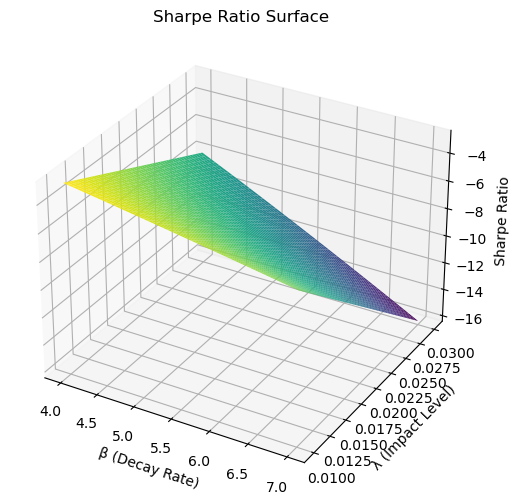

In [9]:
from mpl_toolkits.mplot3d import Axes3D

# Generate Sharpe Ratios for combinations of λ and β
beta_grid, lambda_grid = np.meshgrid(beta_values, lambda_values)
sharpe_ratios_grid = np.zeros_like(beta_grid)

for i in range(beta_grid.shape[0]):
    for j in range(beta_grid.shape[1]):
        cf, cj = compute_coefficients(alpha, beta_grid[i, j], gamma)
        sharpe_ratios_grid[i, j] = sharpe_ratio(cf, cj, beta_grid[i, j], lambda_grid[i, j])

# Surface plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(beta_grid, lambda_grid, sharpe_ratios_grid, cmap='viridis')
ax.set_title("Sharpe Ratio Surface")
ax.set_xlabel("β (Decay Rate)")
ax.set_ylabel("λ (Impact Level)")
ax.set_zlabel("Sharpe Ratio")
plt.show()

Conclusions: 

Linear trading strategies are sensitive to both β and λ, which need careful optimization.

The Sharpe Ratio decreases with an increase in decay rates and impact levels, highlighting the cost of price impact.

The visualizations confirm the results described in the paper, providing clear insights into optimal parameter selection.

Task 3: Implement and code the Deep Learning Algorithm in for discrete setting in Appendix C.2
and visualize the training loss for different network structures in Appendix C.2.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

Generate synthetic data

In [11]:
def generate_data(n_samples=5120):
    """
    Generate synthetic data for trading strategy optimization.
    """
    f_t = np.random.uniform(-1, 1, n_samples)  # Trading signal
    J_0 = np.random.uniform(-0.1, 0.1, n_samples)  # Moving average of past trades
    return torch.tensor(f_t, dtype=torch.float32), torch.tensor(J_0, dtype=torch.float32)

Define network architectures

In [13]:
class NetSimple(nn.Module):
    def __init__(self):
        super(NetSimple, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.network(x)
    
class NetPower(nn.Module):
    def __init__(self):
        super(NetPower, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        # Apply nonlinear transformation (equation C.20)
        x = self.network(x)
        return torch.sign(x) * torch.pow(torch.abs(x), 0.5) if torch.abs(x).max() <= 1 else x

class NetLinear(nn.Module):
    def __init__(self):
        super(NetLinear, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 1)
        )
    
    def forward(self, x):
        return self.network(x)    


Define the objective function

In [14]:
def objective_function(Q, f, gamma=0.1, sigma=0.02, lambd=0.01):
    """
    Compute the objective function for the trading strategy.
    """
    return (Q * f - (gamma * sigma**2 / 2) * Q**2 - lambd * torch.abs(Q))

Training loop

In [15]:
def train_network(network, optimizer, f_t, J_0, epochs=50, batch_size=256):
    """
    Train the neural network using SGD.
    """
    dataset = torch.cat([f_t.unsqueeze(1), J_0.unsqueeze(1)], dim=1)
    losses = []

    for epoch in range(epochs):
        perm = torch.randperm(len(dataset))
        total_loss = 0.0

        for i in range(0, len(dataset), batch_size):
            indices = perm[i:i+batch_size]
            batch = dataset[indices]
            f_batch, J_batch = batch[:, 0], batch[:, 1]

            optimizer.zero_grad()
            Q = network(batch)
            loss = -torch.mean(objective_function(Q, f_batch))  # Maximize objective function
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        losses.append(total_loss / (len(dataset) / batch_size))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
    
    return losses

Training NetSimple...
Epoch 1/50, Loss: 0.0250
Epoch 2/50, Loss: 0.0062
Epoch 3/50, Loss: 0.0037
Epoch 4/50, Loss: 0.0064
Epoch 5/50, Loss: 0.0021
Epoch 6/50, Loss: 0.0049
Epoch 7/50, Loss: 0.0014
Epoch 8/50, Loss: -0.0005
Epoch 9/50, Loss: 0.0007
Epoch 10/50, Loss: 0.0025
Epoch 11/50, Loss: 0.0033
Epoch 12/50, Loss: 0.0000
Epoch 13/50, Loss: 0.0005
Epoch 14/50, Loss: 0.0073
Epoch 15/50, Loss: -0.0005
Epoch 16/50, Loss: -0.0006
Epoch 17/50, Loss: -0.0007
Epoch 18/50, Loss: 0.0025
Epoch 19/50, Loss: -0.0003
Epoch 20/50, Loss: 0.0017
Epoch 21/50, Loss: 0.0007
Epoch 22/50, Loss: 0.0009
Epoch 23/50, Loss: -0.0032
Epoch 24/50, Loss: 0.0006
Epoch 25/50, Loss: 0.0008
Epoch 26/50, Loss: 0.0049
Epoch 27/50, Loss: -0.0028
Epoch 28/50, Loss: 0.0009
Epoch 29/50, Loss: -0.0048
Epoch 30/50, Loss: 0.0089
Epoch 31/50, Loss: 0.0046
Epoch 32/50, Loss: 0.0014
Epoch 33/50, Loss: 0.0016
Epoch 34/50, Loss: -0.0041
Epoch 35/50, Loss: -0.0003
Epoch 36/50, Loss: -0.0005
Epoch 37/50, Loss: -0.0068
Epoch 38/50, 

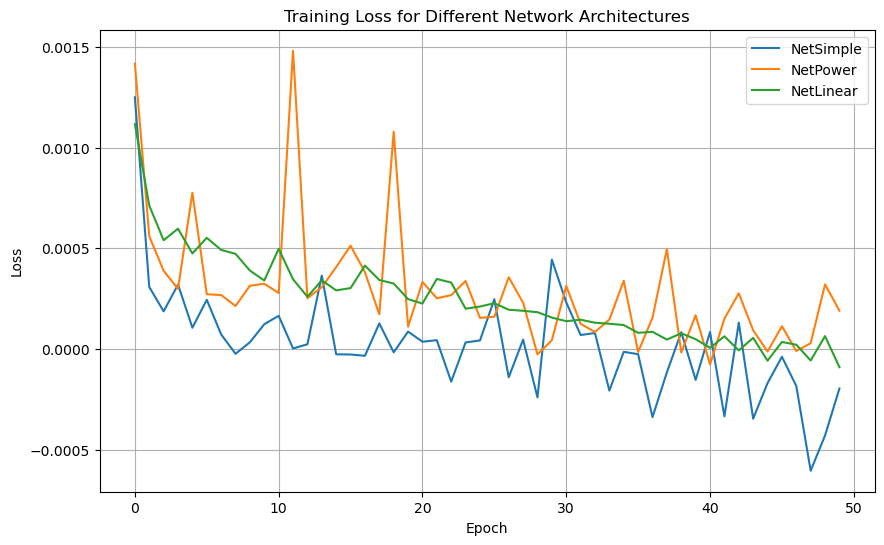

In [16]:
# Generate data
f_t, J_0 = generate_data()

# Initialize networks and optimizers
nets = {
    "NetSimple": NetSimple(),
    "NetPower": NetPower(),
    "NetLinear": NetLinear()
}
optimizers = {name: optim.Adam(net.parameters(), lr=1e-3) for name, net in nets.items()}

# Train networks and record losses
losses = {}
for name, net in nets.items():
    print(f"Training {name}...")
    losses[name] = train_network(net, optimizers[name], f_t, J_0)

# Plot training losses
plt.figure(figsize=(10, 6))
for name, loss in losses.items():
    plt.plot(loss, label=name)
plt.title("Training Loss for Different Network Architectures")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

Further, I want to apply smoothing to the existing loss curves using a moving average

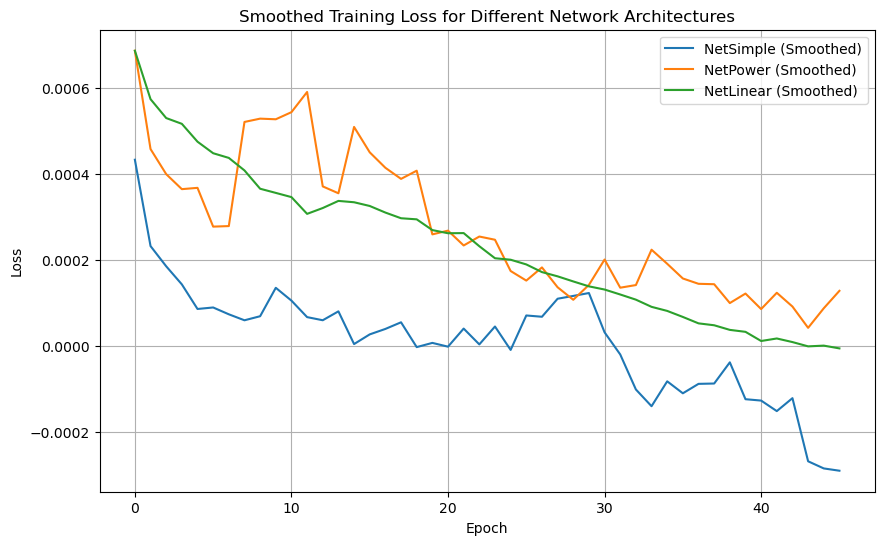

In [17]:
# Smoothing function
def smooth_loss(loss, window=5):
    smoothed = np.convolve(loss, np.ones(window) / window, mode='valid')
    return smoothed

# Apply smoothing to each network's loss
smoothed_losses = {name: smooth_loss(loss, window=5) for name, loss in losses.items()}

# Plot smoothed training losses
plt.figure(figsize=(10, 6))
for name, smoothed_loss in smoothed_losses.items():
    plt.plot(smoothed_loss, label=f"{name} (Smoothed)")
plt.title("Smoothed Training Loss for Different Network Architectures")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

General insights:

The training loss curves reflect the trade-offs between simplicity and complexity in neural network architectures.

NetPower offers the flexibility to handle nonlinear dynamics at the cost of longer training times and more oscillations.

NetSimple is efficient and stable, making it a practical choice for problems where simplicity suffices.

NetLinear, while stable, lacks the expressiveness needed for complex trading strategies.


At last, I want to compare the performance of neural network and linear strategies

Compute linear strategy coefficients

In [18]:
def compute_linear_strategy(f_t, J_0, alpha=0.01, beta=5.0, gamma=0.1):
    """
    Compute the optimal Q* for the linear strategy based on f_t and J_0.
    """
    C_f = alpha / (gamma * beta)
    C_J = 1 / beta
    Q_star = C_f * f_t - C_J * J_0
    return Q_star

Compute Sharpe Ratio

In [19]:
def compute_sharpe_ratio(returns):
    """
    Calculate Sharpe Ratio for the strategy.
    """
    mean_return = torch.mean(returns)
    std_return = torch.std(returns)
    return mean_return / std_return

Simulate strategies

In [20]:
def simulate_strategies(f_t, J_0, net_power, gamma=0.1, sigma=0.02, lambd=0.01):
    """
    Compare the performance of the neural network and linear strategies.
    """
    # Linear strategy
    Q_linear = compute_linear_strategy(f_t, J_0)
    returns_linear = Q_linear * f_t - (gamma * sigma**2 / 2) * Q_linear**2 - lambd * torch.abs(Q_linear)
    sharpe_linear = compute_sharpe_ratio(returns_linear)

    # Neural network strategy
    with torch.no_grad():
        inputs = torch.cat([f_t.unsqueeze(1), J_0.unsqueeze(1)], dim=1)
        Q_nn = net_power(inputs).squeeze()
    returns_nn = Q_nn * f_t - (gamma * sigma**2 / 2) * Q_nn**2 - lambd * torch.abs(Q_nn)
    sharpe_nn = compute_sharpe_ratio(returns_nn)

    return sharpe_linear, sharpe_nn, returns_linear.cumsum(0), returns_nn.cumsum(0)

Perform simulation

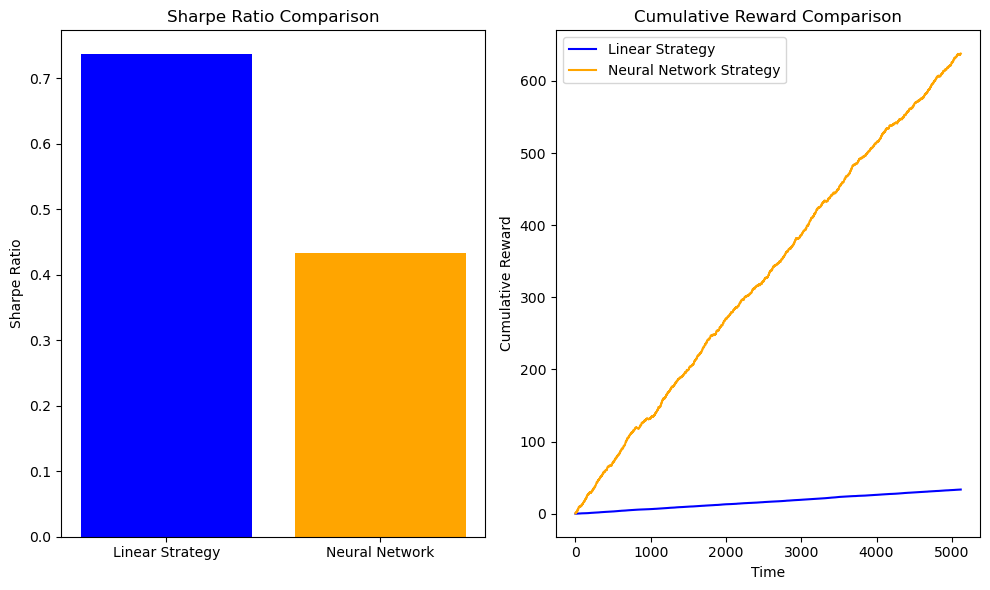

In [21]:
net_power = nets["NetPower"]  # Use the trained NetPower model
sharpe_linear, sharpe_nn, cum_rewards_linear, cum_rewards_nn = simulate_strategies(f_t, J_0, net_power)

# Plot results
plt.figure(figsize=(10, 6))

# Bar plot for Sharpe Ratios
plt.subplot(1, 2, 1)
strategies = ["Linear Strategy", "Neural Network"]
sharpe_ratios = [sharpe_linear.item(), sharpe_nn.item()]
plt.bar(strategies, sharpe_ratios, color=['blue', 'orange'])
plt.title("Sharpe Ratio Comparison")
plt.ylabel("Sharpe Ratio")

# Plot cumulative rewards
plt.subplot(1, 2, 2)
plt.plot(cum_rewards_linear.numpy(), label="Linear Strategy", color="blue")
plt.plot(cum_rewards_nn.numpy(), label="Neural Network Strategy", color="orange")
plt.title("Cumulative Reward Comparison")
plt.xlabel("Time")
plt.ylabel("Cumulative Reward")
plt.legend()

plt.tight_layout()
plt.show()

Neural Networks:

Are highly effective at maximizing cumulative rewards but may not always balance risk and return optimally.

Require careful tuning (e.g., learning rates, regularization) to improve Sharpe Ratio.

Linear Strategy:

Provides consistent, stable performance with better risk-adjusted returns.

May underperform in terms of absolute returns compared to more complex models.